In [ ]:
%matplotlib inline

#### Requirements



1.   Connect colab to your google drive
2.   Navigate into the folder where the unet is stored



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
import sys
sys.path.insert(0, '../gdrive/MyDrive/unet-nested-multiple-classification')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import argparse
import logging
import os
import os.path as osp
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from unet import NestedUNet
from unet import UNet
from utils.dataset import BasicDataset
from config import UNetConfig

from losses import LovaszLossSoftmax
from losses import LovaszLossHinge
from losses import dice_coeff

import albumentations as A
import albumentations.augmentations.functional as Fu
from albumentations.pytorch.transforms import ToTensorV2
import copy

from os.path import splitext
from os import listdir

from glob import glob

from torchvision.transforms import functional as func
from numpy import moveaxis
import matplotlib.pyplot as plt

#### Adding relative paths of image and mask folders

In [ ]:
# These are the relative paths to the google drive folders
# If neccessary, change paths to the respective image and mask folders on your local drive

dir_img_train = '../gdrive/MyDrive/unet-nested-multiple-classification/data/images/images_training/'
dir_mask_train = '../gdrive/MyDrive/unet-nested-multiple-classification/data/masks/masks_grayscale/'
dir_checkpoint = '../gdrive/MyDrive/unet-nested-multiple-classification/data/checkpoints/'

## Data Augmentation

Returns a list of the filenames of those session you want <br>
Parameter: <br>


-directory: directory where images/masks are stored <br>
-sessions: session numbers you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) <br>







In [ ]:
def getSelectedFilenames(directory, sessions):
    all_filenames = list(sorted(os.listdir(directory)))
    selected_filenames = []
  
    for session in sessions:
        string = 'aicm' + session
        for name in all_filenames:
            if string in name:
                selected_filenames.append(name)
 
    return selected_filenames

Returns a list of the filenames of those session you want <br>
Parameter: <br>


-images_directory: directory where images are stored <br>
-masks_directory: directory where masks are stored <br>
-sessions: session numbers you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) <br>
-transform: albumentations compose object - optional, just add for training data, you don't need augmented pictures for validation






In [ ]:
# Creates dataset with training and validation images
class CustomDataset(Dataset):
    def __init__(self, images_directory, masks_directory, sessions, transform=None):   
        self.images_filenames = getSelectedFilenames(images_directory, sessions);
        self.images_directory = images_directory;
        self.masks_directory = masks_directory;
        self.transform = transform;
        self.sessions = sessions           

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]

        pathImage = os.path.join(self.images_directory, image_filename);
        pathMask = os.path.join(self.masks_directory, image_filename);
        
        pillow_image = Image.open(pathImage)
        image = np.array(pillow_image)
        pillow_mask = Image.open(pathMask).convert('L')
        mask = np.array(pillow_mask)
                
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = np.array(image)
            mask = np.array(mask)
         
          #to get channels_first format
          #image_np = moveaxis(image_np, 2,0)
                    
         
          #image_tensor = torch.from_numpy(image_np).type(torch.FloatTensor)
          #mask_tensor = torch.from_numpy(mask_np).type(torch.FloatTensor)
        
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image)
        
        
#         image = func.pil_to_tensor(pillow_image)
#         mask = func.pil_to_tensor(pillow_mask)
#         image = func.to_tensor(np.array(image))
#         mask = func.to_tensor(np.array(mask)) 


        return {
            'image': image,
            'mask':  mask
        }

    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans         
        
# Augmentation of images
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur (blur_limit=4, always_apply=False, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5)
])

Set up training and validation datasets <br>


Parameter: <br>

-dir_img_train: directory where images for training are stored <br>
-dir_mask_train: directory where masks for training are stored <br>
-dir_img_val: directory where images for validation are stored <br>
-dir_mask_val: directory where masks for validation are stored <br>
-train_transform: albumentations compose object for training images/masks, which you want to augment
-sessions_train: session numbers of training_data you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07'])  <br>
  -sessions_val: session numbers of training_data you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) 






In [ ]:
def setupDatasets(dir_img_train, dir_mask_train, dir_img_val, dir_mask_val ,train_transform, sessions_train, sessions_val):
    train_dataset = CustomDataset(dir_img_train, dir_mask_train, sessions_train, train_transform)
    val_dataset = CustomDataset(dir_img_val, dir_mask_val, sessions_val)
    return train_dataset, val_dataset

trainingData, validationData = setupDatasets(dir_img, dir_mask, dir_img, dir_mask, train_transform, ["03","04","05","06","07","08","09"], ["10"]) 

# print((trainingData.__getitem__(5)['image'].shape))
# print((trainingData.__getitem__(5)['mask'].shape))
# print((validationData.__getitem__(5)['image'].shape))
# print((validationData.__getitem__(5)['mask'].shape))

Visualization of different augmentations applied to the same image and the associated mask

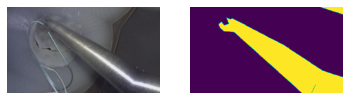

In [ ]:
def visualize(dataset):
    index = np.random.choice(dataset.__len__(), 1)
    dictionary = dataset.__getitem__(6);

    image, mask = dictionary["image"], dictionary["mask"]
    image = image.numpy().transpose((1,2,0))
    mask = mask.numpy().transpose((1,2,0))
 
    plt.subplot(1, 2, 1) 
    plt.axis("off")
    plt.imshow(image)

    plt.subplot(1, 2, 2) 
    plt.axis("off")
    plt.imshow(np.squeeze(mask))  # zero'th channel is the background, 1st channel is the foreground or gauss points

visualize(trainingData)

#### Train network

In [ ]:
# Change UNet configuration if necessary
# Also important to change n_channels and n_classes
cfg = UNetConfig()

# Training function
def train_net(net, cfg, train_dataset, val_dataset):
    # Define amount of training and validation images
    n_val = len(val_dataset)
    n_train = len(train_dataset)
    
    # Load training and validation datasets
    train = train_dataset
    val = val_dataset
   
    train_loader = DataLoader(train,
                              batch_size=cfg.batch_size,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True)
    val_loader = DataLoader(val,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)
    
    # Creates a log file for tensorboard visualization
    writer = SummaryWriter(comment=f'LR_{cfg.lr}_BS_{cfg.batch_size}_SCALE_{cfg.scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {cfg.epochs}
        Batch size:      {cfg.batch_size}
        Learning rate:   {cfg.lr}
        Optimizer:       {cfg.optimizer}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {cfg.save_cp}
        Device:          {device.type}
        Images scaling:  {cfg.scale}
    ''')

    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(),
                               lr=cfg.lr)
    elif cfg.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(),
                                  lr=cfg.lr,
                                  weight_decay=cfg.weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(),
                              lr=cfg.lr,
                              momentum=cfg.momentum,
                              weight_decay=cfg.weight_decay,
                              nesterov=cfg.nesterov)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=cfg.lr_decay_milestones,
                                               gamma = cfg.lr_decay_gamma)
    
    # Defines the loss function of the training
    if cfg.n_classes > 1:
        criterion = LovaszLossSoftmax()
#         weights = [0.1, 1., 1., 1., 1., 1.]
#         weights = torch.FloatTensor(weights).cuda()
#         criterion = F.cross_entropy()
    else:
        criterion = LovaszLossHinge()
    
    # Training starts here
    for epoch in range(cfg.epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{cfg.epochs}', unit='img') as pbar:
            for batch in train_loader:
                batch_imgs = batch['image']
                batch_masks = batch['mask']
                assert batch_imgs.shape[1] == cfg.n_channels, \
                        f'Network has been defined with {cfg.n_channels} input channels, ' \
                        f'but loaded images have {batch_imgs.shape[1]} channels. Please check that ' \
                        'the images are loaded correctly.'

                batch_imgs = batch_imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
                batch_masks = batch_masks.to(device=device, dtype=mask_type)
                
                # Prediction mask is generated here
                inference_masks = net(batch_imgs)

                # Compares generated mask with ground truth mask
                if cfg.n_classes == 1:
                    inferences = inference_masks.squeeze(1)
                    masks = batch_masks.squeeze(1)
                else:
                    inferences = inference_masks
                    masks = batch_masks

                if cfg.deepsupervision:
                    loss = 0
                    for inference_mask in inferences:
#                         pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)
#                         print(inference_mask.squeeze(dim=1).shape)
#                         print(masks.unsqueeze(1).shape)
#                         loss += F.cross_entropy(inference_mask.unsqueeze(dim=0), masks, weight=weights)
                        loss += criterion(inference_mask, masks)
                    loss /= len(inferences)
                else:
#                     loss = F.cross_entropy(inference_mask.unsqueeze(dim=0), masks, weight=weights)
                    loss = criterion(inferences, masks)
                
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)
                writer.add_scalar('model/lr', optimizer.param_groups[0]['lr'], global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                pbar.update(batch_imgs.shape[0])
                global_step += 1
                
                # This sections calls the evaluation function after each epoch
                if global_step % (n_train // (1 * cfg.batch_size)) == 0:
                    val_score = eval_net(net, val_loader, device, n_val, cfg)
                    
                    # Return dice score for binary segmentation and cross entropy for multi-class segmentation
                    if cfg.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('CrossEntropy/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', batch_imgs, global_step)
                    if cfg.deepsupervision:
                            inference_masks = inference_masks[-1]
                    if cfg.n_classes == 1:
                        inference_mask = torch.sigmoid(inference_masks) > cfg.out_threshold
                        writer.add_images('masks/inference',
                                          inference_mask,
                                          global_step)
                    else:
                        ids = inference_masks.shape[1]  # N x C x H x W
                        inference_masks = torch.chunk(inference_masks, ids, dim=1)
                        for idx in range(0, len(inference_masks)):
                            inference_mask = torch.sigmoid(inference_masks[idx]) > cfg.out_threshold
                            writer.add_images('masks/inference_'+str(idx),
                                              inference_mask,
                                              global_step)
                            
        # Changed cfg.checkpoints_dir to dir_checkpoint
        if cfg.save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass

            ckpt_name = 'epoch_' + str(epoch + 1) + '.pth'
            torch.save(net.state_dict(),
                       osp.join(dir_checkpoint, ckpt_name))
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()
    

# Evaluation function
def eval_net(net, loader, device, n_val, cfg):
    
    net.eval()
    tot = 0

    with tqdm(total=n_val, desc='Validation round', unit='img', position=0, leave=True) as pbar:
        for batch in loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            # Compute loss. Dice for binary segmentation, cross entropy for multi-class segmentation
            if cfg.deepsupervision:
                masks_preds = net(imgs)
                loss = 0
                for masks_pred in masks_preds:
                    tot_cross_entropy = 0
                    for true_mask, pred in zip(true_masks, masks_pred):
                        pred = (pred > cfg.out_threshold).float()
                        if cfg.n_classes > 1:
                            sub_cross_entropy = F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                        else:
                            sub_cross_entropy = dice_coeff(pred, true_mask.squeeze(dim=1)).item()
                        tot_cross_entropy += sub_cross_entropy
                    tot_cross_entropy = tot_cross_entropy / len(masks_preds)
                    tot += tot_cross_entropy
            else:
                masks_pred = net(imgs)
                for true_mask, pred in zip(true_masks, masks_pred):
                    pred = (pred > cfg.out_threshold).float()
                    if cfg.n_classes > 1:
                        tot += F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                    else:
                        tot += dice_coeff(pred, true_mask.squeeze(dim=1)).item()

            pbar.update(imgs.shape[0])

    return tot / n_val

#### Configure training parameters and device

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Automatically uses a GPU, if it is available to torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If you want to train on the CPU un-comment this line
# device = torch.device('cpu')

logging.info(f'Using device {device}')

net = eval(cfg.model)(cfg)
logging.info(f'Network:\n'
             f'\t{cfg.model} model\n'
             f'\t{cfg.n_channels} input channels\n'
             f'\t{cfg.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if cfg.bilinear else "Dilated conv"} upscaling')

if cfg.load:
    net.load_state_dict(
        torch.load(cfg.load, map_location=device)
    )
    logging.info(f'Model loaded from {cfg.load}')

net.to(device=device);
# Faster convolutions, but more memory
# cudnn.benchmark = True

INFO: Using device cuda
INFO: Network:
	NestedUNet model
	3 input channels
	6 output channels (classes)
	Bilinear upscaling


#### Call the training function

In [ ]:
try:
    train_net(net=net, cfg=cfg, train_dataset=trainingData, val_dataset=validationData)
except KeyboardInterrupt:
    
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

INFO: Starting training:
        Epochs:          500
        Batch size:      1
        Learning rate:   0.0001
        Optimizer:       SGD
        Training size:   775
        Validation size: 37
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  4.01img/s]
INFO: Validation cross entropy: 1.933122367472262
Epoch 1/500: 100%|██████████████████████████████████████████████| 775/775 [05:32<00:00,  2.33img/s, loss (batch)=0.746]
INFO: Checkpoint 1 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:23<00:00,  1.59img/s]
INFO: Validation cross entropy: 1.8967378558339298
Epoch 2/500: 100%|██████████████████████████████████████████████| 775/775 [05:39<00:00,  2.28img/s, loss (batch)=0.753]
INFO: Checkpoint 2 saved !
Validation round: 100%|███████████████████████████████████████████████████

Epoch 25/500: 100%|█████████████████████████████████████████████| 775/775 [05:28<00:00,  2.36img/s, loss (batch)=0.453]
INFO: Checkpoint 25 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83img/s]
INFO: Validation cross entropy: 1.138754815668673
Epoch 26/500: 100%|█████████████████████████████████████████████| 775/775 [05:31<00:00,  2.34img/s, loss (batch)=0.525]
INFO: Checkpoint 26 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.10img/s]
INFO: Validation cross entropy: 1.0962765925639384
Epoch 27/500: 100%|█████████████████████████████████████████████| 775/775 [05:28<00:00,  2.36img/s, loss (batch)=0.281]
INFO: Checkpoint 27 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82img/s]
INFO: Validation cross entropy: 1.0964249018076304
Epoch 28/500: 100%|█████████████████████████

Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.09img/s]
INFO: Validation cross entropy: 1.11072990378818
Epoch 51/500: 100%|█████████████████████████████████████████████| 775/775 [05:32<00:00,  2.33img/s, loss (batch)=0.243]
INFO: Checkpoint 51 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83img/s]
INFO: Validation cross entropy: 1.1167770044223682
Epoch 52/500: 100%|█████████████████████████████████████████████| 775/775 [05:32<00:00,  2.33img/s, loss (batch)=0.322]
INFO: Checkpoint 52 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.09img/s]
INFO: Validation cross entropy: 1.1092295711104934
Epoch 53/500: 100%|█████████████████████████████████████████████| 775/775 [05:30<00:00,  2.35img/s, loss (batch)=0.313]
INFO: Checkpoint 53 saved !
Validation round: 100%|██████████████████████

Epoch 76/500: 100%|████████████████████████████████████████████| 775/775 [05:31<00:00,  2.34img/s, loss (batch)=0.0581]
INFO: Checkpoint 76 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.10img/s]
INFO: Validation cross entropy: 1.0974092032458331
Epoch 77/500: 100%|████████████████████████████████████████████| 775/775 [05:28<00:00,  2.36img/s, loss (batch)=0.0514]
INFO: Checkpoint 77 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83img/s]
INFO: Validation cross entropy: 1.1104554550067798
Epoch 78/500: 100%|████████████████████████████████████████████| 775/775 [05:31<00:00,  2.34img/s, loss (batch)=0.0255]
INFO: Checkpoint 78 saved !
Validation round: 100%|███████████████████████████████████████████████████████████████| 37/37 [00:17<00:00,  2.10img/s]
INFO: Validation cross entropy: 1.1055298528155766
Epoch 79/500: 100%|████████████████████████

Epoch 102/500:   2%|▊                                            | 13/775 [00:06<06:08,  2.07img/s, loss (batch)=0.203]
INFO: Saved interrupt
